In [50]:
import importlib
import shiftNMF_frozen
importlib.reload(shiftNMF_frozen)
from shiftNMF_frozen import ShiftNMF
from nnls_l1 import nnls
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from helpers.generators import *
from helpers.data import X_WINE, PPM_WINE
import Hardmodel_single_peaks
importlib.reload(Hardmodel_single_peaks)
from Hardmodel_single_peaks import Single_Model
from Hardmodel import Hard_Model
import scipy
from scipy.signal import find_peaks
import itertools
from helpers.fit_functions import *

# shiftNMF

[5.99978451 5.99915313 5.99852176 ... 0.50114961 0.50051823 0.49988686]
3.600563858141756
3.474289087241136


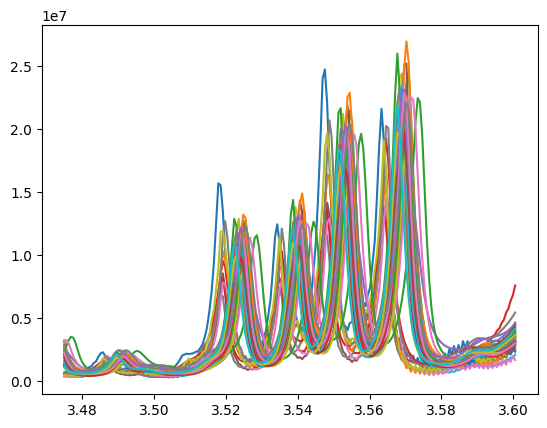

In [63]:
si = 3800
ei = 4000
print(PPM_WINE)
X = X_WINE[:,si:ei]
print(PPM_WINE[si])
print(PPM_WINE[ei])
ppm = PPM_WINE[si:ei]

plt.plot(ppm,X.T)
plt.show()

epoch: 1000, Loss: 0.014197638763865525, Tau: 310.4625581289956


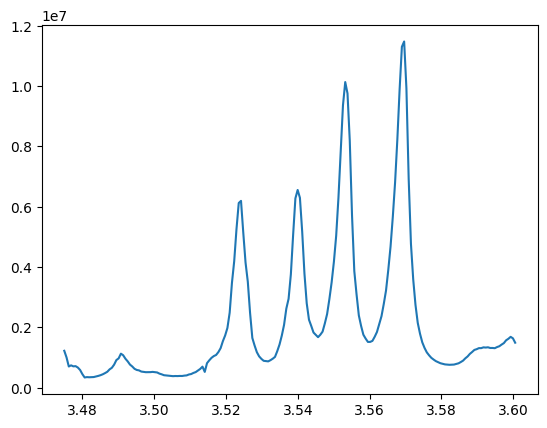

In [64]:

nmf = ShiftNMF(X, 1, lr=0.1, alpha=1e-6, min_imp=0.001)
W_est, H_est, tau_est = nmf.fit(verbose=1, max_iter=1000, tau_iter=0, Lambda=0.000)
plt.plot(ppm,H_est.T)
plt.show()


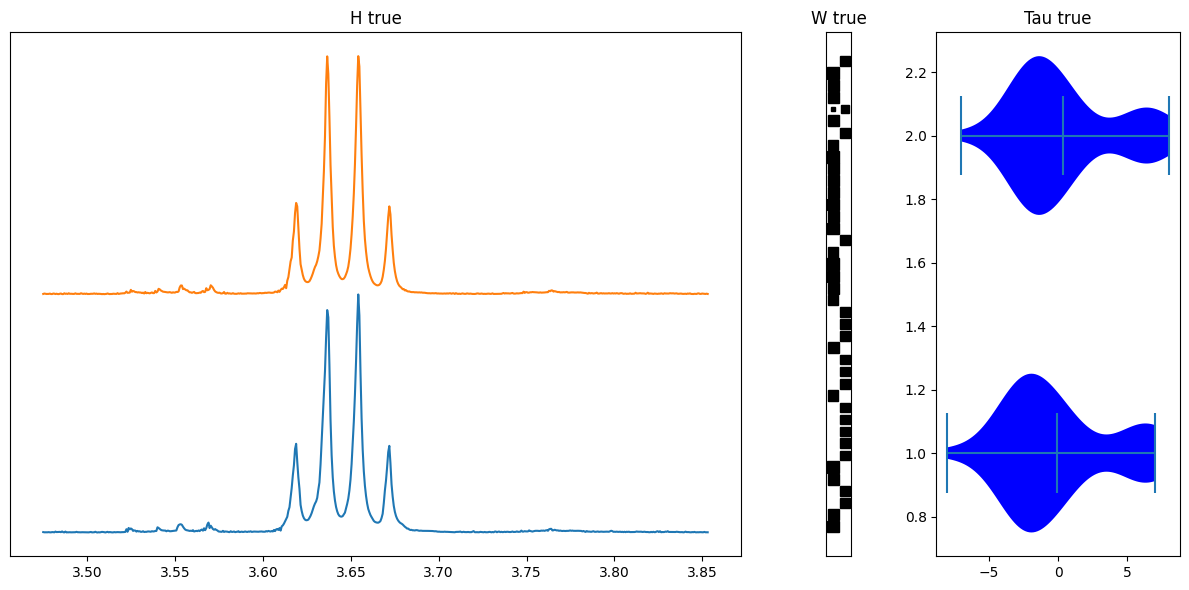

In [62]:
from helpers.plot import *
gs = gridspec.GridSpec(1, 3, width_ratios=[3, 1, 1])

fig = plt.figure(figsize=(12, 6))
N, M = X[:,0:3000].shape
H_scaled = np.zeros_like(H_est)
for i, vec in enumerate(H_est):
    H_scaled[i] = vec/max(vec)

# Plot H and H_est
ax1 = plt.subplot(gs[0])
plotSpaced(ax1, ppm, H_scaled.T)
ax1.set_title('H true')

ax2 = plt.subplot(gs[1])
ax2.set_title('W true')
hinton(W_est.T, ax=ax2)

ax3 = plt.subplot(gs[2])
violin_parts = ax3.violinplot(tau_est, showmeans=True, showmedians=False, vert=False)
ax3.set_title('Tau true')
change_violin_colors(violin_parts, color_list=['blue']*N)
# change_violin_colors(violin_parts, [l.get_color() for l in ax3.get_children()[:3]])

# Set tight layout
plt.tight_layout()
plt.show()

# Hardmodel

Found peaks:[ 50  75  97 122]
sigma: 3.745218166181466 n:0.9999978120101432
sigma: 4.017616287759962 n:0.9999990419124449
sigma: 3.7918657468699295 n:0.9999997938301631
sigma: 3.983336541289905 n:0.9999995201430032
Lorentzian %:s: 0.17798466143996472
tensor([1., 1., 1., 1.], grad_fn=<SigmoidBackward0>)
Sigma:
Parameter containing:
tensor([-46.0450,  30.3432, -24.8634, -24.6719], requires_grad=True)
HERER ARE THE SINGLE FITS SIGMAS
[-46.044975  30.343178 -24.863434 -24.671919]
hypothesises:
{(0, 1), (1, 3), (2,), (1, 2), (0, 1, 2), (0, 1, 3), (0, 3), (0, 2, 3), (1, 2, 3), (2, 3), (1,), (0, 2), (0, 1, 2, 3), (0,), (3,)}

initial values:
means:
tensor([ 62.5000,  98.5000,  97.0000,  86.0000,  74.0000,  82.3333,  86.0000,
         89.6667,  98.0000, 109.5000,  75.0000,  73.5000,  86.0000,  50.0000,
        122.0000])
sigmas:
Parameter containing:
tensor([4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.],
       requires_grad=True)
spacing(J-coupling):
Parameter containing:
tensor

c:\Bachelorprojekt\nlars.py:64: LinAlgWarning: Ill-conditioned matrix (rcond=1.39537e-08): result may not be accurate.
  w = solve(XtX[np.ix_(A, A)], s)
c:\Bachelorprojekt\nlars.py:64: LinAlgWarning: Ill-conditioned matrix (rcond=3.59696e-09): result may not be accurate.
  w = solve(XtX[np.ix_(A, A)], s)


epoch: 1, Loss: 0.08611508092539621
epoch: 2, Loss: 0.08611508092539621
means:
[62.5      82.333336 86.       89.666664 73.5      86.      ]
sigmas:
[4. 4. 4. 4. 4. 4.]
J coupling:
[25. 25. 72. 47. 47. 25.]
multiplicity
[2 3 2 3 2 4]
N
[1. 1. 1. 1. 1. 1.]
W:
[[20.462046    0.          0.          0.          0.          2.2132862
  19.198002    0.40889663  0.          0.          0.          2.4736881
   8.626364    0.          0.        ]]


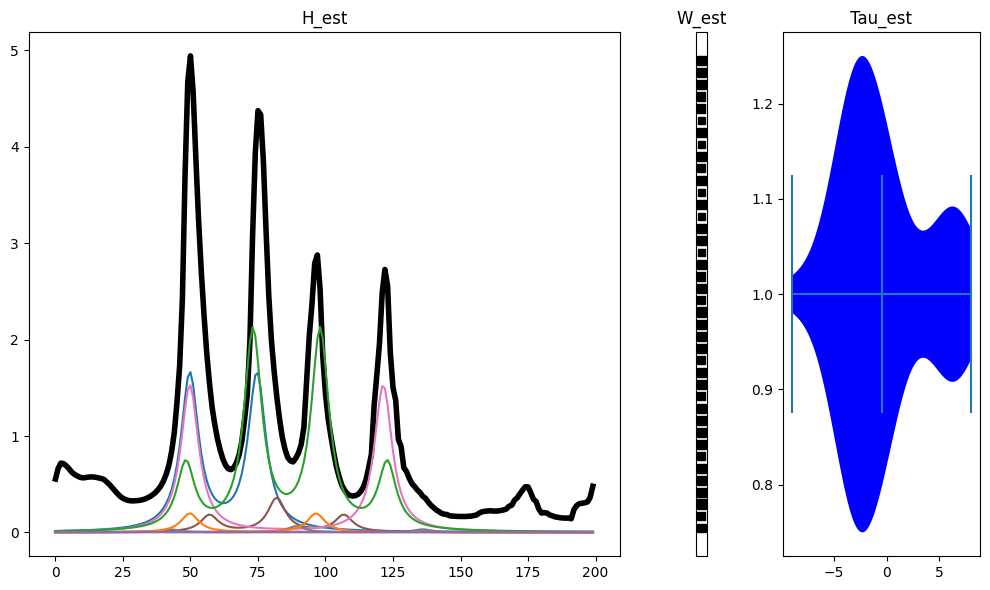

In [53]:

fig = plt.figure(figsize=(10, 6))
# Create a gridspec object with 2 rows and 3 columns
gs = gridspec.GridSpec(1, 3, width_ratios=[3, 1, 1])

# Plot H and H_est
ax1 = plt.subplot(gs[0])
# plotSpaced(ax1, np.arange(H_est.shape[1]), H_est.T)
ax1.set_title('H_est')
x = np.arange(H_est.shape[1])

ax2 = plt.subplot(gs[1])
ax2.set_title('W_est')
hinton(W_est.T, ax=ax2)

ax3 = plt.subplot(gs[2])
violin_parts = ax3.violinplot(tau_est, showmeans=True, showmedians=False, vert=False)
ax3.set_title('Tau_est')
change_violin_colors(violin_parts, color_list=['blue']*3)
# change_violin_colors(violin_parts, [l.get_color() for l in ax3.get_children()[:3]])

# plt.figure(figsize=(15,5))
# plt.plot(H_est.T)
# plt.savefig("shiftcomponents")
# plt.clf()
ymax = 0
for i in range(len(H_est)):
    ymax = max(ymax,(H_est[i]/np.std(H_est[i])).max())
yoffset = ymax
reg_paths = []
lambda_axis = []
C_path = []

for i in range(len(H_est)):
    means, sigmas, n = single_fit(H_est[i], min_height=0.5, min_sigma=1)
    #diff_matrix = calc_difference_matrix(sigmas)
    print("HERER ARE THE SINGLE FITS SIGMAS")
    print(sigmas)
    sigmas = np.array([4,4,4,4])
    diff_matrix = calc_difference_matrix(np.ones((len(sigmas))))
    hypothesis = peak_hypothesis(diff_matrix, cutoff=10/100)
    hardmodel = Hard_Model(H_est[i], hypothesis, means, sigmas, n, lr=10, alpha = 1e-3, factor=1, patience=1, min_imp=0.01)

    W, C, running_loss, path, lambdas = hardmodel.fit(verbose=True, return_loss=True)
    reg_paths.append(path)
    lambda_axis.append(lambdas)
    C_path.append(C)
    means, sigma, j_coup, mult, n = hardmodel.return_values()
    print("means:")
    print(means)
    print("sigmas:")
    print(sigma)
    print("J coupling:")
    print(j_coup)
    print("multiplicity")
    print(mult)
    print("N")
    print(n)

    print("W:")
    print(W)
    ## TODO change this to be the true underlying components from H_ART not the shift found components, they need to be scaled accordingly.
    # plt.figure(figsize=(15,5))
    # plt.plot(H_est[i]/np.std(H_est[i]), linewidth=5, color="k")
    ax1.plot(x,H_est[i]/np.std(H_est[i])+yoffset*i, linewidth=4, color="k")
    for j, vec in enumerate(C):
        ax1.plot(x,vec*W[:,j]+yoffset*i)
# Set tight layout
plt.tight_layout()
plt.show()

[ 1.47178272e+01  2.41335660e+00  2.17029265e+00  1.64832038e+00
  6.34125954e-01  5.15544794e-01  1.57441179e-01  1.51169788e-01
  2.12198106e-02  2.51953147e-08 -6.85374110e-04]


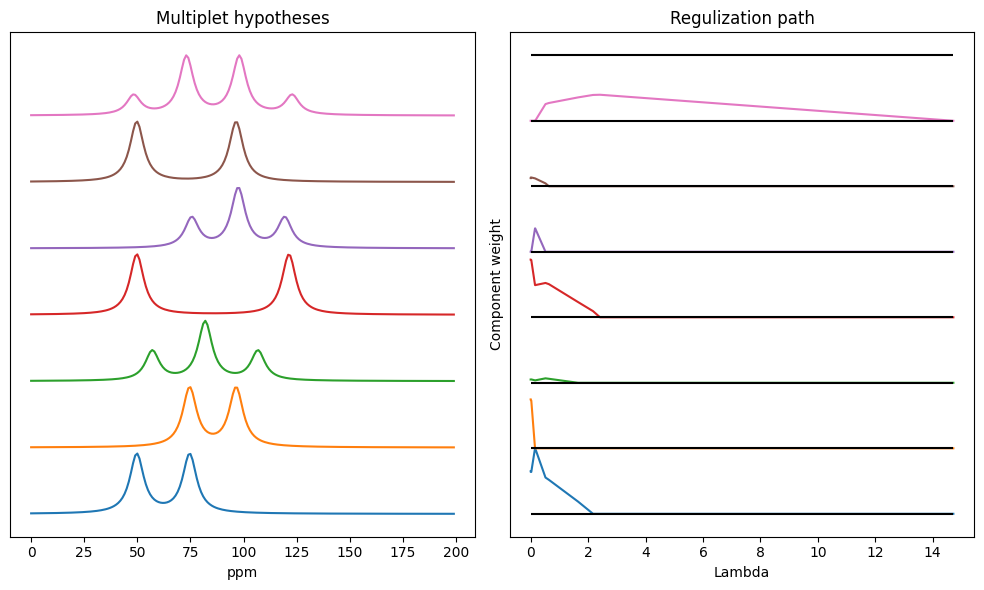

In [59]:

for i in range(len(reg_paths)):
    path = reg_paths[i]
    lambdas = lambda_axis[i]
    print(lambdas[0])
    C = C_path[i]

    fig = plt.figure(figsize=(10, 6))
    # Create a gridspec object with 2 rows and 3 columns
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])

    # Plot H and H_est
    ax1 = plt.subplot(gs[0])
    # plotSpaced(ax1, np.arange(H_est.shape[1]), H_est.T)
    ax1.set_title('Multiplet hypotheses')

    ax1.set_xlabel("ppm")
   
    x = np.arange(H_est.shape[1])

    ax2 = plt.subplot(gs[1])
    ax2.set_title('Regulization path')
    ax2.set_xlabel("Lambda")
    ax2.set_ylabel("Component weight")

    ax1.tick_params(left = False, labelleft = False)
    ax2.tick_params(left = False, labelleft = False)

    ymax = 1.1
    # for j, vec in enumerate(C):
    #     ymax = max(ymax,(C[j]/max(C[j])).max())

    cutoff = [0]*5

    yoffset = ymax
    t = 0
    for j, vec in enumerate(C):
        if any(path[0][j] > cutoff[i]):
            ax1.plot(x,vec/max(vec)+yoffset*t)
            t += 1

    
    ymax = path[0].max()
    yoffset = ymax
    t = 0
    for j, vec in enumerate(C):
        if any(path[0][j] > cutoff[i]):
            ax2.plot(lambdas[0],path[0][j]+yoffset*t)
            ax2.hlines(yoffset*t,lambdas[0][-1],lambdas[0][0], color="k")
            t +=1
    ax2.hlines(yoffset*t,lambdas[0][-1],lambdas[0][0], color="k")

    #plt.title("Hardmodelled component regulization path")
    #plt.plot(lambdas[0], reg_paths[i][0].T)
    # plt.savefig("fig"+str(i)+"_path")
    plt.tight_layout()
    plt.show()